In [1]:
# decoding JPEG images and decoding/encoding RLE datasets
# !pip3 install -q pylibjpeg==1.4.0
# https://github.com/pydicom/pylibjpeg
# !pip3 install pydicom==2.3.0
## !pip3 install -q python-gdcm==3.0.20
# !pip3 install -q torchvision==0.12.0
# !pip3 install -q torchaudio==0.11.0
# !pip3 install -q torchmetrics==0.11.0
# !pip3 install -q torchtext==0.12.0
# !pip3 install -q torch==1.13.1 # cuda 'sm_86' is only supported by 1.13.1
# !pip3 install -q timm==0.4.12
# !pip3 -q install monai==1.1.0
# !pip3 -q install segmentation-models-pytorch==0.2.1
# !conda install -c pytorch magma-cuda110==2.5.2
# !pip3 install opencv-python==4.5.4.60

In [2]:
DEBUG = False

import os
import sys


In [3]:
# suitable for kaggle notebook
# sys.path = ['../ca_2',] + sys.path
# print(sys.path)

In [4]:
import argparse
import warnings

In [5]:
import gc, ast, cv2, time, pickle, random
import pylibjpeg
import gdcm
import pydicom
# pydicom is a pure Python package for working with DICOM files. 
# -It lets you read, modify and write DICOM data in an easy "pythonic" way. 

In [6]:
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image


import nibabel as nib
# read / write access to some common neuroimaging file formats

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold



In [8]:
%matplotlib inline

In [9]:
from monai.transforms import Resize

/home/na/miniconda3/envs/base_2/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/na/miniconda3/envs/base_2/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
import  monai.transforms as transforms

In [11]:
import timm

import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


In [12]:
from tqdm import tqdm

In [13]:
import graphviz

In [14]:
# pip3 install torchview
from torchview import draw_graph

In [15]:
# graphviz.set_jupyter_format('png')

In [16]:
np.set_printoptions(threshold=sys.maxsize)

In [17]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', None) # 500
pd.set_option('expand_frame_repr', True)

In [18]:
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"]="1"

device = torch.device('cuda')

# benchmark mode is good whenever your input sizes for your network do not vary. 
# This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
torch.backends.cudnn.benchmark = True

# Config

In [15]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5

# check models performance => https://github.com/rwightman/pytorch-image-models/blob/main/results/results-imagenet.csv
backbone = 'resnet18d' # 'resnet18d' # 'tf_efficientnetv2_s_in21ft1k <=> tf_efficientnetv2_s.in21k_ft_in1k'

image_sizes = [128, 128, 128]
R = Resize(image_sizes, mode="area") # monai => Resize

init_lr = 3e-3
batch_size = 2
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1 # to avoid overfitting

data_dir = './' # ../input/rsna-2022-cervical-spine-fracture-detection
use_amp = True
num_workers = 12
out_dim = 7

n_epochs = 300 # 1000

log_dir = './logs'
model_dir = './models'
model_dir_seg = './kaggle'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [20]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])

# transforms_train =''
# transforms_valid =''

# DataFrame

In [21]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    #            StudyInstanceUID    patient_overall    C1  C2  C3  C4  C5  C6  C7
    # 0   1.2.826.0.1.3680043.6200                 1    1   1   0   0   0   0   0

mask_files = os.listdir(f'{data_dir}segmentations')

df_mask = pd.DataFrame({ 'mask_file': mask_files, })
    #     mask_file
    # 0   1.2.826.0.1.3680043.30487.nii
    # 1   1.2.826.0.1.3680043.30640.nii

df_mask['StudyInstanceUID'] = df_mask['mask_file'].apply(lambda x: x[:-4])
    #     mask_file                       StudyInstanceUID
    # 0   1.2.826.0.1.3680043.30487.nii   1.2.826.0.1.3680043.30487

df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir, 'segmentations', x))
    #     mask_file                                       StudyInstanceUID
    # 0   ./segmentations/1.2.826.0.1.3680043.30487.nii   1.2.826.0.1.3680043.30487


df_train = df_train.merge(df_mask, on='StudyInstanceUID', how='left')
    #             StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  mask_file
    # 0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0   Nan
    # 1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0   Nan
del df_mask

df_train['image_folder'] = df_train['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir, 'train_images', x))
    #             StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  mask_file  image_folder
    # 0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0   Nan       ./train_images/1.2.826.0.1.3680043.6200      
    # 1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0   Nan       ./train_images/1.2.826.0.1.3680043.27262

df_train['mask_file'].fillna('', inplace=True)
    #             StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  mask_file  image_folder
    # 0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0             ./train_images/1.2.826.0.1.3680043.6200      
    # 1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0             ./train_images/1.2.826.0.1.3680043.27262
    
df_seg = df_train.query('mask_file != ""').reset_index(drop=True)
    # dropping rows with df['mask_file'] == ''
    # equivalent to 
    # df_seg = df_train[df_train['mask_file'] != ""].reset_index(drop=True)
    

kf = KFold(5) # n_splits=5
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)): # X=df_seg, y =df_seg
    df_seg.loc[valid_idx, 'fold'] = fold # df_seg.loc[row_index, column_fold] = fold_number
# fold column represents the split_number / fold_number in which row falls.


In [22]:
# 1.2.826.0.1.3680043.20574 not present in the dataset
df_seg[df_seg['StudyInstanceUID'] == '1.2.826.0.1.3680043.20574']

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,fold


In [23]:
df_seg.head(4)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,fold
0,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,./segmentations/1.2.826.0.1.3680043.1363.nii,./train_images/1.2.826.0.1.3680043.1363,0
1,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,./segmentations/1.2.826.0.1.3680043.25704.nii,./train_images/1.2.826.0.1.3680043.25704,0
2,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,./segmentations/1.2.826.0.1.3680043.20647.nii,./train_images/1.2.826.0.1.3680043.20647,0
3,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,./segmentations/1.2.826.0.1.3680043.31077.nii,./train_images/1.2.826.0.1.3680043.31077,0


In [24]:
df_seg.tail(3)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,fold
84,1.2.826.0.1.3680043.28025,0,0,0,0,0,0,0,0,./segmentations/1.2.826.0.1.3680043.28025.nii,./train_images/1.2.826.0.1.3680043.28025,4
85,1.2.826.0.1.3680043.21321,1,1,1,1,0,0,0,1,./segmentations/1.2.826.0.1.3680043.21321.nii,./train_images/1.2.826.0.1.3680043.21321,4
86,1.2.826.0.1.3680043.26990,1,0,0,0,0,1,1,1,./segmentations/1.2.826.0.1.3680043.26990.nii,./train_images/1.2.826.0.1.3680043.26990,4


In [25]:
# df_seg.to_csv('df_seg_train_1.csv', index=False)

# Dataset

In [26]:
# df_seg = pd.read_csv('df_seg_train_1.csv')

In [27]:
# df_seg.tail(4)

In [28]:
# Here is the list of inverted (z-axis) segmentation masks:
revert_list = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [29]:
def load_dicom(path):
    # path => ./train_images/1.2.826.0.1.3680043.1363/1.dcm       
    dicom = pydicom.read_file(path)
    #     dicom =>
    #     Dataset.file_meta -------------------------------
    #     (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
    #     (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
    #     (0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.1363.1.1
    #     (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
    #     (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
    #     (0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
    #     -------------------------------------------------
    #     (0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.1363.1.1
    #     (0008, 0023) Content Date                        DA: '20220727'
    #     (0008, 0033) Content Time                        TM: '183924.353110'
    #     (0010, 0010) Patient's Name                      PN: '1363'
    #     (0010, 0020) Patient ID                          LO: '1363'
    #     (0018, 0050) Slice Thickness                     DS: '1.0'
    #     (0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.3680043.1363
    #     (0020, 000e) Series Instance UID                 UI: 1.2.826.0.1.3680043.1363.1
    #     (0020, 0013) Instance Number                     IS: '1'
    #     (0020, 0032) Image Position (Patient)            DS: [-149.2080078125, -350.2080078125, 54]
    #     (0020, 0037) Image Orientation (Patient)         DS: [1, 0, 0, 0, 1, 0]
    #     (0028, 0002) Samples per Pixel                   US: 1
    #     (0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
    #     (0028, 0010) Rows                                US: 512
    #     (0028, 0011) Columns                             US: 512
    #     (0028, 0030) Pixel Spacing                       DS: [0.583984375, 0.583984375]
    #     (0028, 0100) Bits Allocated                      US: 16
    #     (0028, 0101) Bits Stored                         US: 12
    #     (0028, 0102) High Bit                            US: 11
    #     (0028, 0103) Pixel Representation                US: 0
    #     (0028, 1050) Window Center                       DS: [450, 40]
    #     (0028, 1051) Window Width                        DS: [1500, 350]
    #     (0028, 1052) Rescale Intercept                   DS: '-1024.0'
    #     (0028, 1053) Rescale Slope                       DS: '1.0'
    #     (7fe0, 0010) Pixel Data                          OW: Array of 524288 elements    
       
    data = dicom.pixel_array
        # data => 
        # [[ 22  35  53 ...  46  80  33]
        #  [ 49  12  44 ...  58  52  11]    
        #          ...
        #          ...
        #  [11  54  31 ... 112  64  99]
        #  [371 280 242 ...  67  24   0]] 
        # data.shape => (512, 512) i.e., (Rows, Columns)    
        # np.unique(data) => [0    1    2    3    4    5    ......   3156 3163 3182 3200 3228 3267 3274]

    
    data = cv2.resize(data, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_AREA)
        # If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation. 
        # If you are shrinking the image, you should prefer to use INTER_AREA interpolation.    
        # data =>
        # [[ 40  45  57 ...  30  27  44]
        #  [ 40  50  52 ...  38  26  26]
        #      ...
        #      ...
        #  [ 99 158 234 ... 151 159 180]
        #  [155  91  74 ...  50 134 103]] 
        # data.shape => (128,128) i.e., (image_sizes[0], image_sizes[1])
        # np.unique(data) => [18   21   22   23   24   25   26   27   ........ 2684 2716 2727 2755 2791 2875]
        
    return data


def load_dicom_line_par(path):
    # path => ./train_images/1.2.826.0.1.3680043.1363

    t_paths = sorted(glob(os.path.join(path, "*")),\
                     key=lambda x: int(x.split('/')[-1].split(".")[0]))
    # glob(os.path.join(path, "*")) => ['./train_images/1.2.826.0.1.3680043.1363/179.dcm', 
    #                                        './train_images/1.2.826.0.1.3680043.1363/174.dcm',..........    
    # "./train_images/1.2.826.0.1.3680043.1363/179.dcm".split('/')[-1].split(".")[0] => 179
    # t_paths => ['./train_images/1.2.826.0.1.3680043.1363/1.dcm', 
    #                                        './train_images/1.2.826.0.1.3680043.1363/2.dcm',..........
    

    n_scans = len(t_paths) # number of scans in path; e.g. 199
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
    # np.linspace(0., 1., 128) => array([0.        , 0.00787402, 0.01574803, 0.02362205, ...., 1. ])
    # np.linspace(start, stop, num_of_samples_to_generate, ...) => Return evenly spaced numbers over a specified interval.
    # image_sizes[2] => defined in 'config' section above
    # list(range(199)) = [0,1,2,3,.......,199]
    # np.quantile([0,1,2,3,.......,199], array([0.        , 0.00787402, 0.01574803, 0.02362205, ...., 1. ]))
    # np.quantile(Input,  sequence of quantiles to compute between 0 and 1, ...)
    # indices => [  0   2   3   5   6   8   9  11  12  14  16  17  19  20  22  23  25  27 ............ 198]    
    # len(indices) => 128
    # even if n_scans is less than 128, the len(indices) remained 128. As, quantiles are repeated.
    
    t_paths = [t_paths[i] for i in indices] 
    # selecting 'image_sizes[2]' no. of elements from t_paths
    # previous 199 now 128
    

    images = []
    for filename in t_paths:
        images.append(load_dicom(filename))
    # images => list all images, where each image is in 'array' form with shape (128,128).

    images = np.stack(images, 0)
    # np.stack(arrays, axis, out=None, ...) => Join a sequence of arrays along a new axis.    
    #  images.shape => (128, 128, 128) i.e., (z,x,y)
    #  first axis is z axis (represents number of images) and (x,y) is per image shape.
    # images => 
    # [[[ 39  30  37 ...  30  40  37]
    #   [ 32  38  29 ...  27  36  34]
    #   [ 27  36  40 ...  30  30  33]

    #   ...
    #   ...
    #   ...

    #   [ 66  71  83 ...  78  69  68]
    #   [ 74  67  63 ...  63  60  68]
    #   [ 69  73  65 ...  72  74  71]]]  
    
    
    # normalization section
    images = images - np.min(images)
        # np.min(images) => minimum value in (z,x,y) matrix    
    images = images / (np.max(images) + 1e-4)
        # images=>
        # [[[0.00953098 0.00727364 0.00902935 ... 0.00727364 0.00978179 0.00902935]
        #   [0.00777527 0.00928016 0.00702282 ... 0.00652119 0.00877853 0.0082769 ]
        #   [0.00652119 0.00877853 0.00978179 ... 0.00727364 0.00727364 0.00802608]
        #   ...
        #   ...

    # normalized values are too low thus multiplying by 255 to stay within the range.
    images = (images * 255).astype(np.uint8)
        # prior to any type of transformation(resize, augmentation etc.) convert data to uint8.    
        
        # with ".astype(np.uint8)", images =>
        # [[[ 2  1  2 ...  1  2  2]
        #   [ 1  2  1 ...  1  2  2]
        #   [ 1  2  2 ...  1  1  2]    
        #   ...
        #   ...

        # without ".astype(np.uint8)", images =>
        # [[[ 2.43039874  1.85477798  2.30248301 ...  1.85477798  2.4943566  2.30248301]
        #   [ 1.9826937   2.36644087  1.79082012 ...  1.6629044   2.23852515  2.11060943]
        #   [ 1.6629044   2.23852515  2.4943566  ...  1.85477798  1.85477798  2.04665157]
        #     ...
        #     ...

    return images, indices


def load_sample(row, has_mask=True):
    # row =>
    # index                                                          0
    # StudyInstanceUID                        1.2.826.0.1.3680043.1363
    # patient_overall                                                1
    # C1                                                             0
    # C2                                                             0
    # C3                                                             0
    # C4                                                             0
    # C5                                                             1
    # C6                                                             0
    # C7                                                             0
    # mask_file           ./segmentations/1.2.826.0.1.3680043.1363.nii
    # image_folder             ./train_images/1.2.826.0.1.3680043.1363
    # fold                                                           0
    # Name: 0, dtype: object    
    
    image, index = load_dicom_line_par(row.image_folder)
    # image.shape => (128,128,128)
    # image.ndim => 3    
    
    if image.ndim < 4: # number of dimension is less 4
        image = np.expand_dims(image, axis=0).repeat(repeats=3, axis=0)  # to 3ch
        # np.expand_dims(image, axis=0) => (1,128,128,128)
        # image.shape => (3,128,128,128) i.e., repeatition of (128,128,128) three times
        # image.ndim => 4            

    if has_mask:
        # reading nii file
        # to ask for the array data is to call the get_fdata()
        mask_org = nib.load(row.mask_file).get_fdata()
            # np.min(mask_org, np.max(mask_org) => 0.0, 10.0
            # np.unique(mask_org) => [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
        
        shape = mask_org.shape
            # type(mask_org) => <class 'numpy.memmap'> 
            # shape => (512, 512, 199) i.e., (0,1,2)
            # 199 number of slices/images (each patient have different-2 slices/images)
                        
            
        if row.StudyInstanceUID in revert_list:
            # trasposing such that mask will be in orientation with image
            mask_org = mask_org.transpose((2, 1, 0))[:, ::-1, :]  
                # np.transpose(a, axes=(2, 1, 0)) => Returns an array with axes transposed.
                # mask_org.shape => (199, 512, 512)                        
        else:
            # trasposing such that mask will be in orientation with image
            mask_org = mask_org.transpose((2, 1, 0))[::-1, ::-1, :-1:]  
                # np.transpose(a, axes=(2, 1, 0)) => Returns an array with axes transposed.
                # mask_org.shape => (199, 512, 512)            
            
        mask_org = mask_org[index]  # picking same indexes from 199, as in images
            # mask_org.shape => (128, 512, 512)        
        
        shape = mask_org.shape

        mask = np.zeros((7, shape[0], shape[1], shape[2]))
            # mask.shape => (7,128,512,512) # we only intereseted in seven mask for (seven cervical vertebrae C1 to C7)   
        for cId in range(7):
            mask[cId] = (mask_org == (cId+1))
                # (mask_org == (cid+1)) ==>
                # [[[False False False ... False False False]
                #   [False False False ... False False False]
                #   [False False False ... False False False]
                #   ...
                #   ...
                #   [False False False ... False False False]
                #   [False False False ... False False False]
                #   [False False False ... False False False]]]
                
        # mask.shape => (7, 128, 512, 512)
        # np.min(mask), np.max(mask) => 0., 1.

        mask = mask.astype(np.uint8) * 255        
        # np.min(mask), np.max(mask) => 0, 255        
        # np.unique(mask) => [0 255]        
            
        shape = mask.shape    
            
            # mask.shape => (7, 128, 512, 512) => 7 = channels, [128,512,512] = spatial dimension 
        mask = R(mask).numpy() 
            # type(mask), mask.shape, np.min(mask), np.max(mask)  => np.ndarray, (7, 128, 128, 128), 0, 255
            # np.unique(mask) => [0  15  31  47  63  79  95 111 127 143 159 175 191 207 223 239 255]         

        return image, mask
    else:
        return image



class SEGDataset(torch.utils.data.Dataset): 
# An abstract class representing a Dataset.
# An abstract class is a class, but not one you can create objects from directly. Its purpose is to define how other classes should look like, i.e. what methods and properties they are expected to have.
    def __init__(self, df, mode, transform):
        
        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]                

#         image, mask = load_sample(row, has_mask=True)
            
#             # np.min(image), np.max(image) => 0 254
#             # mask.shape, np.min(mask), np.max(mask) => (7, 128, 128, 128), 0, 255
#             # np.unique(mask) => [ 0  15  31  47  63  79  95 111 127 143 159 175 191 207 223 239 255]
#         res = self.transform({'image':image, 'mask':mask}) # returns torch array
#         image = res['image'] / 255. # scaling high image values otherwise no display. 
#         mask = res['mask']
# #         image = image / 255.  # for view without transform
        
#             # mask.shape, np.min(mask), np.max(mask) => torch.Size([7, 128, 128, 128]), 0.0, 255.0 
#             # np.unique(mask) => [0.  15.  31.  47.  63.  79.  95. 111. 127. 143. 159. 175. 191. 207. 223. 239. 255.]
#         mask = (mask > 127).astype(np.float32) # 255/2 = 127.5 so convert '<127 to 0' and '>127 to 1'.
#             # np.min(image), np.max(image) => 0.0, 1.0
#             # mask.shape, np.min(mask), np.max(mask), np.unique(mask) => (7, 128, 128, 128), 0.0, 1.0, [0. 1.]
        
        ### using local cache
        image_file = os.path.join(data_dir, f'numpy/{row.StudyInstanceUID}.npy')
        mask_file = os.path.join(data_dir, f'numpy/{row.StudyInstanceUID}_mask.npy')
#         np.save(image_file, image)
#         np.save(mask_file, mask)
        
        image = np.load(image_file)
        mask = np.load(mask_file)
                
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()        
        
        return image, mask


In [30]:
# # storing image, mask => in numpy formats
# df_show = df_seg
# dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)
# for index, row in df_show.iterrows():
#     img, mask = dataset_show[index]

In [31]:
# df_show = df_seg[0:4] # testing only few value
# dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)

In [32]:
# # for debugging
# img, mask = dataset_show[0]

In [33]:
# # viewing some images
# plt.rcParams["figure.figsize"] = (20,8)
# for i in range(1): # 2
#     f, axarr = plt.subplots(1,8)
#     for p in range(4):
#         idx = i*4+p
#         img, mask = dataset_show[idx]
#             # img.shape, mask.shape => (3, 128, 128, 128) (7, 128, 128, 128)        
        
#         img = img[:, 60, :, :] # checking 60th dcm image for a particular patient       
#         mask = mask[:, 60, :, :] # checking corresponding 60th slice 
#             # img.shape, mask.shape => (3, 128, 128) (7, 128, 128)        
        
#         # merging 7 channels in order to reduce to 3
#         mask[0] = mask[0] + mask[3] + mask[6] # merging C1, C4 and C7
#         mask[1] = mask[1] + mask[4] # merging C2, C5
#         mask[2] = mask[2] + mask[5] # merging C3, C6
        
#         mask = mask[:3] # selecting only 3 sequence / channels out of 7.
#             # mask.shape => (3, 128, 128)


#         axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze()) # squeeze(); removes axes of length one.
#         axarr[p+4].imshow(mask.transpose(0, 1).transpose(1,2).squeeze())        

            
# for i in range(1): # 2
#     f, axarr = plt.subplots(1,4)
#     for p in range(4):
#         idx = i*4+p
#         img, mask = dataset_show[idx]        
#         img = img[:, 60, :, :] # checking 60th dcm image for a particular patient       
#         mask = mask[:, 60, :, :] # checking corresponding 60th slice 
        
#         # merging 7 channels in order to reduce to 3
#         mask[0] = mask[0] + mask[3] + mask[6] # merging C1, C4 and C7
#         mask[1] = mask[1] + mask[4] # merging C2, C5
#         mask[2] = mask[2] + mask[5] # merging C3, C6
        
#         mask = mask[:3] # selecting only 3 sequence / channels out of 7.
            
#         img = img * 0.7 + mask * 0.3 # merging image and its mask
#             # img.shape => (3, 128, 128)           
#         axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())  # squeeze(); removes axes of length one.

# Model

In [16]:
class TimmSegModel(nn.Module):  # nn.Module: Base class for all neural network modules.
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3, # number of channels for input
            features_only=True, 
            # output feature maps for selected levels. leave output of encoder.
            # default, 5 strides will be output from most of models.
            
            drop_rate=drop_rate, # set the dropout rate for training.
            drop_path_rate=drop_path_rate, # stochastic depth rate. to “deactivate” some layers during training.
            pretrained=pretrained
        )
        # self.encoder => for summary
        # self.encoder.default_cfg =>        
        # {'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth', 
        #  'input_size': (3, 224, 224), 'pool_size': (7, 7), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 
        #  'std': (0.229, 0.224, 0.225), 'first_conv': 'conv1.0', 'architecture': 'resnet18d'}
        
        # self.encoder.feature_info.module_name() => ['act1', 'layer1', 'layer2', 'layer3', 'layer4']
        # self.encoder.feature_info.channels() => [64, 64, 128, 256, 512]
        # self.encoder.feature_info.reduction() => [2, 4, 8, 16, 32]        

        g = self.encoder(torch.rand(1, 3, 64, 64))
        # torch.rand(*size) => Returns a tensor filled with random numbers from a uniform distribution on the interval [0, 1)[0,1)
        # type(g) => list
        # len(g) => 5
        # g[0].shape, g[1].shape, g[2].shape, g[3].shape, g[4].shape =>
        # torch.Size([1, 64, 32, 32]), torch.Size([1, 64, 16, 16]), 
        # torch.Size([1, 128, 8, 8]), torch.Size([1, 256, 4, 4]),
        # torch.Size([1, 512, 2, 2])
        # number of channels is consistent with: self.encoder.feature_info.channels()               
        
        encoder_channels = [1] + [_.shape[1] for _ in g]
        # encoder_channels => [1, 64, 64, 128, 256, 512]
            
        decoder_channels = [256, 128, 64, 32, 16]        # resnet18d
        
        if segtype == 'unet':
            # resnet is in list of supported encoders to the smp
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],                
                decoder_channels=decoder_channels[:n_blocks],
                # List of integers which specify in_channels parameter for convolutions used in decoder.                
                
                n_blocks=n_blocks, # n_blocks=encoder_depth,
                attention_type = 'scse',                
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # nn.Conv2d(in_channels, out_channels,...) => 
        # Applies a 2D convolution over an input signal composed of several input planes.

    def forward(self,x):
        # x => torch.Size([1, 3, 128, 128, 128]); 1 => batch_size

        global_features = [0] + self.encoder(x)[:n_blocks]
        # global_features[0], global_features[1].shape, global_features[2].shape, global_features[3].shape, global_features[4].shape =>
        # 0 torch.Size([1, 64, 64, 64, 64]) torch.Size([1, 64, 32, 32, 32]) torch.Size([1, 128, 16, 16, 16]) torch.Size([1, 256, 8, 8, 8])
        
        seg_features = self.decoder(*global_features) # (*global_features) is equivalent to (global_features[0], global_features[1], global_features[2]...)
        # seg_features.shape => torch.Size([1, 32, 128, 128, 128])

        seg_features = self.segmentation_head(seg_features)
        # seg_features.shape => torch.Size([1, 7, 128, 128, 128])
        return seg_features

In [17]:
from conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        
        # module => BatchNorm2d
        # affine – a boolean value that when set to True, this module has learnable affine parameters.
        # parameters weight and bias are only defined if the argument affine is set to True.
        if module.affine:
            # torch.no_grad() temporarily sets all of the requires_grad flags to false.
            # 'requires_grad' flag is set then model will compute gradient w.r.t to parameter.
            with torch.no_grad():
            # with => ensures that resource is "cleaned up" when the code that uses it finishes running, even if exceptions are thrown.
            # with torch.no_grad() => disable gradient calculation in this context.
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module( name, convert_3d(child) )
    del module

    return module_output

In [18]:
# m = TimmSegModel(backbone)
#     # m => <class '__main__.TimmSegModel'>
#     # TimmSegModel(
#     #   (encoder): FeatureListNet(
#     #     (conv1): Sequential(
#     #       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#     #  .....
#     #  .....

# # all 2d layers are converted to 3d
# m = convert_3d(m)
#     # m => <class '__main__.TimmSegModel'>
#     # TimmSegModel(
#     #   (encoder): FeatureListNet(
#     #     (conv1): Sequential(
#     #       (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
#     #  .....
#     #  .....

# # m(torch.rand(1, 3, 128,128,128)).shape
# # m(torch.rand(1, 3, 128,128,128)).shape => torch.Size([1, 7, 128, 128, 128])

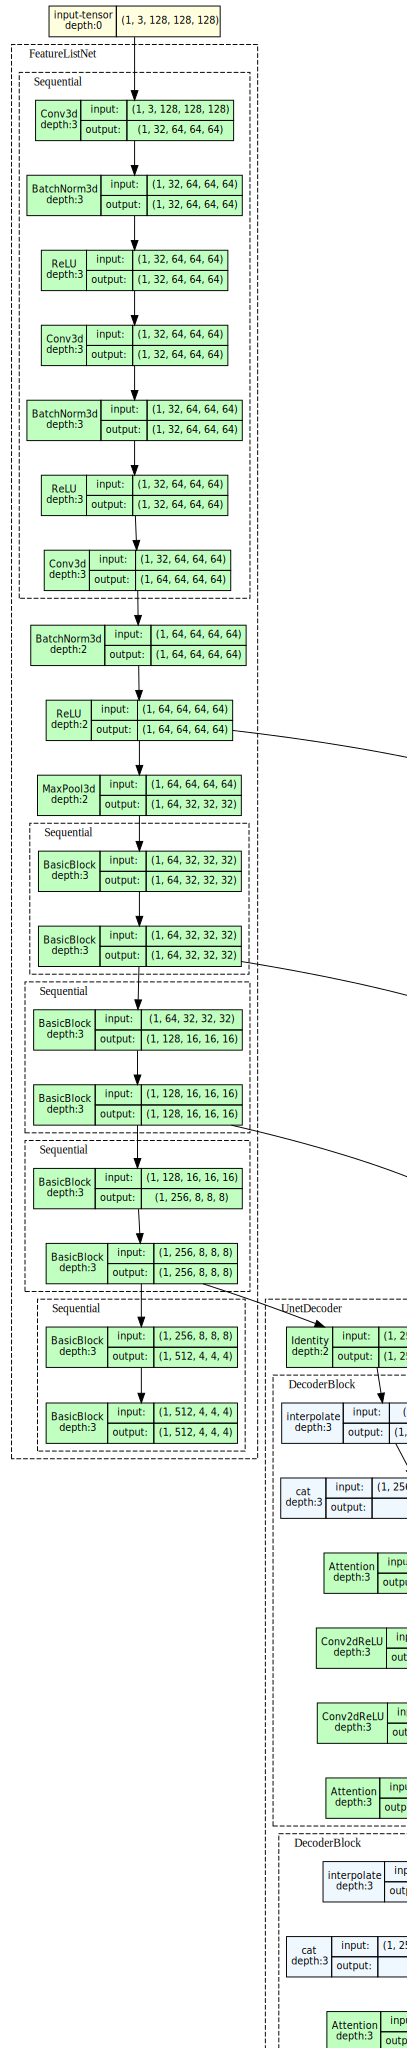

In [19]:
# draw_graph(m, input_data = torch.rand(1, 3, 128,128,128), expand_nested=True, save_graph=True).visual_graph

# Loss & Metric

In [38]:
from typing import Any, Dict, Optional


def binary_dice_score( y_pred: torch.Tensor, y_true: torch.Tensor, threshold: Optional[float] = None, nan_score_on_empty=False, eps: float = 1e-7,) -> float:
    # ->; is introduced to get developers to optionally specify the return type of the function.    

    # y_pred.shape, y_true.shape => torch.Size([128, 128, 128]) torch.Size([128, 128, 128])
    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    # flags
    has_predicted = torch.sum(y_pred) > 0    
    has_targets = torch.sum(y_true) > 0 # tensor(True) or tensor(False)

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score( y_true: torch.Tensor, y_pred: torch.Tensor, threshold=None, eps=1e-7, nan_score_on_empty=False,):
    dice_of_lblS = [] # C1....C7 are labels

    # y_pred.shape => torch.Size([7, 128, 128, 128])
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        dice_of_lbl = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        dice_of_lblS.append(dice_of_lbl)

    return dice_of_lblS


def dice_loss(input, target):
    # torch.sigmoid(input) => Computes the expit (also known as the logistic sigmoid function) of the elements of input.
    input = torch.sigmoid(input)
    # input.shape => torch.Size([4, 7, 128, 128, 128])
    
    smooth = 1.0
    
    # flattens the input tensor
    iflat = input.view(-1)
    # iflat.shape => torch.Size([58720256]) => 4*7*128*128*128 so much dimension

    # flattens the target tensor
    tflat = target.view(-1)
    # tflat.shape => torch.Size([58720256]) => 4*7*128*128*128 so much dimension
    
    intersection = (iflat * tflat).sum()
    # intersection => tensor(82505.0234, device='cuda:0', grad_fn=<SumBackward0>)
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights): # loss_weights = [1,1] => defined in config section    
    # BCEWithLogitsLoss()(input, target) => This loss combines a Sigmoid layer and the BCELoss in one single class.
    # This version is more numerically stable than using a plain Sigmoid followed by a BCELoss.
    # BCE => Binary Cross Entropy.
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

# Train & Valid func

In [39]:
def mixup(input, truth, clip=[0, 1]):
    # torch.randperm(n, *, ...) => Returns a random permutation of integers from 0 to n - 1.
    indices = torch.randperm(input.size(0))
    # input.size(0) => batch_size => 4
    # indices => tensor([3, 1, 2, 0])
    
    # shuffling batch in batch of images. 
    shuffled_input = input[indices]
    
    # shuffling batch in batch of masks. 
    shuffled_masks = truth[indices]

    # np.random.uniform(low=0.0, high=1.0, size=None) => draw sample(s) from a uniform distribution over the over the half-open interval [low, high).
    lam = np.random.uniform(clip[0], clip[1])
    # lam => 0.632965343426405.

    # mixing 'image batch' with 'shuffled image batch' i.e., type of image transformation
    input = input * lam + shuffled_input * (1 - lam)
    
    return input, truth, shuffled_masks, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)    
    # bar => 0%|                                   | 0/2019 [00:00<?, ?it/s]
    # type(bar) => <class 'tqdm.std.tqdm'>    
        
    for images, gt_masks in bar:
        # to reset the gradients of model parameters. 
        optimizer.zero_grad()
        
        # .cuda() => transfer a tensor from CPU to GPU.
        # .cuda() and .to(device=cuda) are same.
        images = images.cuda()
        # type(images), images.shape => <class 'torch.Tensor'> torch.Size([4, 3, 128, 128, 128]) => 4 is batch_size

        gt_masks = gt_masks.cuda() # gt_masks i.e., get_masks
        # type(gt_masks), gt_masks.shape => <class 'torch.Tensor'> torch.Size([4, 7, 128, 128, 128]) => => 4 is batch_size

        do_mixup = False
        # random.random() => function generates random floating numbers in the range[0.1, 1.0)
        if random.random() < p_mixup: # defined in config, p_mixup=0.1
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        # torch.amp (automatic mixed precision) => mixed precision tries to match each op to its appropriate datatype.
        # autocast() => Instances of autocast serve as context managers or decorators that allow regions of your script to run in mixed precision.
        with amp.autocast():
            # images.shape => torch.Size([4, 3, 128, 128, 128])
            logits = model(images)
            # logits.shape => torch.Size([4, 7, 128, 128, 128])  
            
            # calculating loss using masks as targets
            loss = criterion(logits, gt_masks)

            if do_mixup:
                # calculating loss using shuffled masks as targets
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)
                
        # loss, loss.item() => 
        # tensor(0.8821, device='cuda:0', grad_fn=<DivBackward0>), 0.8821219801902771 
        train_loss.append(loss.item())
        
        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()
        # All gradients produced by scaler.scale(loss).backward() are scaled. 
        # Each scale is calculated on-the-fly.
        
        scaler.step(optimizer)
        # scaler.step() first unscales the gradients of the optimizer's assigned params.        
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        # optimizer's assigned params; parameters which are to be optimized by optimizer.
        
        # Updates the scale for next iteration.
        scaler.update()

        bar.set_description(f'smooth loss:{np.mean(train_loss[-30:]):.4f}')
        # train_loss[-30:] => take last 30 values of train_loss

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    
    ths = [0.5]    
    # ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    
    batch_metrics = [[]] * len(ths) # 
    # if 'len(ths) = 7' then batch_metrics => [[], [], [], [], [], [], []]
        
    bar = tqdm(loader_valid)
    with torch.no_grad():
    # disable gradient calculation in this context.
    
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                # # .detach(); Returns a new Tensor, detached from the current graph.
                # # new Tensor will never require gradient.
                # pred = (logits.sigmoid() > th).float().detach()
                
                for i in range(logits.shape[0]): # logits.shape[0] => batch_size => 
                    tmp = multilabel_dice_score(
                        # .cpu() => copy to cpu
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=th, # 0.5
                    )
                    # len(tmp) => 7
                    # tmp => [0.0, 0.0020704131924468654, 0.0, 0.001438477169412038, 0.0, 0.0, 0.0]
                    
                    batch_metrics[thi].extend(tmp) # extend previous list
            bar.set_description(f'smooth loss:{np.mean(valid_loss[-30:]):.4f}')
            
    # single value of 'batch_metrics[thi]' list contains score of one patient i.e., (128,128,128).
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best threshold:', ths[np.argmax(metrics)], 'best dice of epoch:', np.max(metrics))    

    return np.mean(valid_loss), np.max(metrics)


In [40]:
# plt.rcParams['figure.figsize'] = 20, 2
# optimizer = optim.AdamW(m.parameters(), lr=init_lr)
# scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
# lrs = []
# for epoch in range(1, 1000+1):
#     scheduler_cosine.step(epoch-1)
#     lrs.append(optimizer.param_groups[0]["lr"])
# plt.plot(range(len(lrs)), lrs)

# Training

In [41]:
# df_run_tr = df_seg[0:4]
# df_run_val = df_seg[4:5]
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train) # train_
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid) # valid_
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    
    # https://pytorch.org/docs/stable/notes/cuda.html    
    model = model.to(device) # device = torch.device('cuda')
    
    # if not first run, load previous model
    fold_l = 3
    load_model_file = os.path.join(model_dir_seg, f'{kernel_type}_fold{fold_l}_best.pth')
    sd = torch.load(load_model_file)
    if 'model_state_dict' in sd.keys():
        sd = sd['model_state_dict']
    sd = {k[7:] if k.startswith('module.') else k: sd[k] for k in sd.keys()}
    model.load_state_dict(sd, strict=True)    
    

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(f'Length of dataset_train = {len(dataset_train)}, ', f'Length of dataset_valid = {len(dataset_valid)}')

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        # model training in train_func function
        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

#         # Save Last
#         if not DEBUG:
#             torch.save(
#                 {
#                     'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'scaler_state_dict': scaler.state_dict() if scaler else None,
#                     'score_best': metric_best,
#                 },
#                 model_file.replace('_best', '_last')
#             )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [42]:
torch.cuda.empty_cache()

In [43]:
# print(torch.version.cuda)
# print(torch.cuda.get_arch_list())

In [44]:
# execute this cell twice.
# during first execution do not run all folds in continuity. run every fold after kernel restart.
# during second execution of this cell, choose those weights which performed well from all folds.
run(0)
# run(1) 
# run(2)
# run(3)
# run(4)

# maximum difference of 0.10 between "smooth loss train" and "smooth loss valid" is OK, otherwise reduce the lr.

2023-02-06 19:46:44,575 - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth)
Length of dataset_train = 69,  Length of dataset_valid = 18
Mon Feb  6 19:46:45 2023 Epoch: 1


smooth loss:0.1270: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.55s/it]


best threshold: 0.5 best dice of epoch: 0.7327532278136931
Mon Feb  6 19:48:41 2023 Fold 0, Epoch 1, lr: 0.0030000, train loss: 0.09885, valid loss: 0.12704, metric: 0.732753.
metric_best (0.000000 --> 0.732753). Saving model ...
Mon Feb  6 19:48:42 2023 Epoch: 2


smooth loss:0.1277: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7125707318187993
Mon Feb  6 19:49:16 2023 Fold 0, Epoch 2, lr: 0.0029999, train loss: 0.07820, valid loss: 0.12773, metric: 0.712571.
Mon Feb  6 19:49:16 2023 Epoch: 3


smooth loss:0.1058: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.23it/s]


best threshold: 0.5 best dice of epoch: 0.7850353417029181
Mon Feb  6 19:49:51 2023 Fold 0, Epoch 3, lr: 0.0029997, train loss: 0.06105, valid loss: 0.10576, metric: 0.785035.
metric_best (0.732753 --> 0.785035). Saving model ...
Mon Feb  6 19:49:51 2023 Epoch: 4


smooth loss:0.0950: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8037295700757121
Mon Feb  6 19:50:26 2023 Fold 0, Epoch 4, lr: 0.0029993, train loss: 0.05134, valid loss: 0.09497, metric: 0.803730.
metric_best (0.785035 --> 0.803730). Saving model ...
Mon Feb  6 19:50:26 2023 Epoch: 5


smooth loss:0.0857: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.24it/s]


best threshold: 0.5 best dice of epoch: 0.8296994878459155
Mon Feb  6 19:51:01 2023 Fold 0, Epoch 5, lr: 0.0029987, train loss: 0.04690, valid loss: 0.08567, metric: 0.829699.
metric_best (0.803730 --> 0.829699). Saving model ...
Mon Feb  6 19:51:01 2023 Epoch: 6


smooth loss:0.0709: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.860299181006748
Mon Feb  6 19:51:35 2023 Fold 0, Epoch 6, lr: 0.0029979, train loss: 0.03966, valid loss: 0.07085, metric: 0.860299.
metric_best (0.829699 --> 0.860299). Saving model ...
Mon Feb  6 19:51:36 2023 Epoch: 7


smooth loss:0.0914: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.820556019577775
Mon Feb  6 19:52:10 2023 Fold 0, Epoch 7, lr: 0.0029970, train loss: 0.06051, valid loss: 0.09140, metric: 0.820556.
Mon Feb  6 19:52:10 2023 Epoch: 8


smooth loss:0.0815: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8225057216311398
Mon Feb  6 19:52:45 2023 Fold 0, Epoch 8, lr: 0.0029960, train loss: 0.04927, valid loss: 0.08155, metric: 0.822506.
Mon Feb  6 19:52:45 2023 Epoch: 9


smooth loss:0.0856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8251674797159001
Mon Feb  6 19:53:19 2023 Fold 0, Epoch 9, lr: 0.0029947, train loss: 0.05064, valid loss: 0.08558, metric: 0.825167.
Mon Feb  6 19:53:19 2023 Epoch: 10


smooth loss:0.0967: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8050661690769026
Mon Feb  6 19:53:53 2023 Fold 0, Epoch 10, lr: 0.0029933, train loss: 0.06021, valid loss: 0.09672, metric: 0.805066.
Mon Feb  6 19:53:53 2023 Epoch: 11


smooth loss:0.0769: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8306304109562263
Mon Feb  6 19:54:28 2023 Fold 0, Epoch 11, lr: 0.0029918, train loss: 0.04140, valid loss: 0.07693, metric: 0.830630.
Mon Feb  6 19:54:28 2023 Epoch: 12


smooth loss:0.0735: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.24it/s]


best threshold: 0.5 best dice of epoch: 0.8397124583841832
Mon Feb  6 19:55:02 2023 Fold 0, Epoch 12, lr: 0.0029901, train loss: 0.03885, valid loss: 0.07346, metric: 0.839712.
Mon Feb  6 19:55:02 2023 Epoch: 13


smooth loss:0.0720: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8492467978304614
Mon Feb  6 19:55:36 2023 Fold 0, Epoch 13, lr: 0.0029882, train loss: 0.03674, valid loss: 0.07198, metric: 0.849247.
Mon Feb  6 19:55:36 2023 Epoch: 14


smooth loss:0.0732: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.24it/s]


best threshold: 0.5 best dice of epoch: 0.8482162924366708
Mon Feb  6 19:56:11 2023 Fold 0, Epoch 14, lr: 0.0029861, train loss: 0.04085, valid loss: 0.07317, metric: 0.848216.
Mon Feb  6 19:56:11 2023 Epoch: 15


smooth loss:0.0739: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8373787080019321
Mon Feb  6 19:56:45 2023 Fold 0, Epoch 15, lr: 0.0029839, train loss: 0.04027, valid loss: 0.07389, metric: 0.837379.
Mon Feb  6 19:56:45 2023 Epoch: 16


smooth loss:0.0727: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.24it/s]


best threshold: 0.5 best dice of epoch: 0.8409671356839243
Mon Feb  6 19:57:19 2023 Fold 0, Epoch 16, lr: 0.0029815, train loss: 0.04406, valid loss: 0.07271, metric: 0.840967.
Mon Feb  6 19:57:19 2023 Epoch: 17


smooth loss:0.0757: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.23it/s]


best threshold: 0.5 best dice of epoch: 0.83674606642808
Mon Feb  6 19:57:54 2023 Fold 0, Epoch 17, lr: 0.0029790, train loss: 0.04536, valid loss: 0.07569, metric: 0.836746.
Mon Feb  6 19:57:54 2023 Epoch: 18


smooth loss:0.0758: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8344229886700849
Mon Feb  6 19:58:28 2023 Fold 0, Epoch 18, lr: 0.0029763, train loss: 0.03754, valid loss: 0.07582, metric: 0.834423.
Mon Feb  6 19:58:28 2023 Epoch: 19


smooth loss:0.0840: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8139878818502614
Mon Feb  6 19:59:03 2023 Fold 0, Epoch 19, lr: 0.0029734, train loss: 0.04356, valid loss: 0.08400, metric: 0.813988.
Mon Feb  6 19:59:03 2023 Epoch: 20


smooth loss:0.0851: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.20it/s]


best threshold: 0.5 best dice of epoch: 0.82155174278452
Mon Feb  6 19:59:38 2023 Fold 0, Epoch 20, lr: 0.0029704, train loss: 0.03331, valid loss: 0.08512, metric: 0.821552.
Mon Feb  6 19:59:38 2023 Epoch: 21


smooth loss:0.0727: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.24it/s]


best threshold: 0.5 best dice of epoch: 0.8474379223161047
Mon Feb  6 20:00:13 2023 Fold 0, Epoch 21, lr: 0.0029672, train loss: 0.03290, valid loss: 0.07274, metric: 0.847438.
Mon Feb  6 20:00:13 2023 Epoch: 22


smooth loss:0.0721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.8489263869828112
Mon Feb  6 20:00:47 2023 Fold 0, Epoch 22, lr: 0.0029639, train loss: 0.04588, valid loss: 0.07212, metric: 0.848926.
Mon Feb  6 20:00:47 2023 Epoch: 23


smooth loss:0.1044: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7607789016035527
Mon Feb  6 20:01:22 2023 Fold 0, Epoch 23, lr: 0.0029604, train loss: 0.04723, valid loss: 0.10439, metric: 0.760779.
Mon Feb  6 20:01:22 2023 Epoch: 24


smooth loss:0.0844: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.8000675649386858
Mon Feb  6 20:01:55 2023 Fold 0, Epoch 24, lr: 0.0029567, train loss: 0.03293, valid loss: 0.08442, metric: 0.800068.
Mon Feb  6 20:01:55 2023 Epoch: 25


smooth loss:0.0826: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7966495558025469
Mon Feb  6 20:02:30 2023 Fold 0, Epoch 25, lr: 0.0029529, train loss: 0.03272, valid loss: 0.08263, metric: 0.796650.
Mon Feb  6 20:02:30 2023 Epoch: 26


smooth loss:0.0811: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.819102570975425
Mon Feb  6 20:03:04 2023 Fold 0, Epoch 26, lr: 0.0029489, train loss: 0.04062, valid loss: 0.08110, metric: 0.819103.
Mon Feb  6 20:03:04 2023 Epoch: 27


smooth loss:0.0951: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7721733345311532
Mon Feb  6 20:03:38 2023 Fold 0, Epoch 27, lr: 0.0029447, train loss: 0.03966, valid loss: 0.09509, metric: 0.772173.
Mon Feb  6 20:03:38 2023 Epoch: 28


smooth loss:0.2170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.5790047087658606
Mon Feb  6 20:04:12 2023 Fold 0, Epoch 28, lr: 0.0029404, train loss: 0.06497, valid loss: 0.21698, metric: 0.579005.
Mon Feb  6 20:04:12 2023 Epoch: 29


smooth loss:0.1918: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.5822319852662365
Mon Feb  6 20:04:46 2023 Fold 0, Epoch 29, lr: 0.0029360, train loss: 0.08138, valid loss: 0.19178, metric: 0.582232.
Mon Feb  6 20:04:46 2023 Epoch: 30


smooth loss:0.1631: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.6486314458816891
Mon Feb  6 20:05:20 2023 Fold 0, Epoch 30, lr: 0.0029314, train loss: 0.08933, valid loss: 0.16305, metric: 0.648631.
Mon Feb  6 20:05:20 2023 Epoch: 31


smooth loss:0.1270: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7267235630311826
Mon Feb  6 20:05:55 2023 Fold 0, Epoch 31, lr: 0.0029266, train loss: 0.05569, valid loss: 0.12695, metric: 0.726724.
Mon Feb  6 20:05:55 2023 Epoch: 32


smooth loss:0.1081: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7631858656658747
Mon Feb  6 20:06:29 2023 Fold 0, Epoch 32, lr: 0.0029217, train loss: 0.06084, valid loss: 0.10810, metric: 0.763186.
Mon Feb  6 20:06:29 2023 Epoch: 33


smooth loss:0.0857: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7996369986115107
Mon Feb  6 20:07:03 2023 Fold 0, Epoch 33, lr: 0.0029166, train loss: 0.04522, valid loss: 0.08573, metric: 0.799637.
Mon Feb  6 20:07:03 2023 Epoch: 34


smooth loss:0.0859: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.8093406637060075
Mon Feb  6 20:07:37 2023 Fold 0, Epoch 34, lr: 0.0029113, train loss: 0.03802, valid loss: 0.08592, metric: 0.809341.
Mon Feb  6 20:07:37 2023 Epoch: 35


smooth loss:0.0879: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8059073057082119
Mon Feb  6 20:08:12 2023 Fold 0, Epoch 35, lr: 0.0029059, train loss: 0.04083, valid loss: 0.08794, metric: 0.805907.
Mon Feb  6 20:08:12 2023 Epoch: 36


smooth loss:0.0907: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7995513414087342
Mon Feb  6 20:08:46 2023 Fold 0, Epoch 36, lr: 0.0029004, train loss: 0.04661, valid loss: 0.09069, metric: 0.799551.
Mon Feb  6 20:08:46 2023 Epoch: 37


smooth loss:0.0856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8101850734301091
Mon Feb  6 20:09:20 2023 Fold 0, Epoch 37, lr: 0.0028947, train loss: 0.03722, valid loss: 0.08560, metric: 0.810185.
Mon Feb  6 20:09:20 2023 Epoch: 38


smooth loss:0.0936: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7929843507633901
Mon Feb  6 20:09:54 2023 Fold 0, Epoch 38, lr: 0.0028888, train loss: 0.03936, valid loss: 0.09359, metric: 0.792984.
Mon Feb  6 20:09:54 2023 Epoch: 39


smooth loss:0.0908: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7988601056279454
Mon Feb  6 20:10:28 2023 Fold 0, Epoch 39, lr: 0.0028828, train loss: 0.04049, valid loss: 0.09082, metric: 0.798860.
Mon Feb  6 20:10:28 2023 Epoch: 40


smooth loss:0.0883: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.28it/s]


best threshold: 0.5 best dice of epoch: 0.8062026401975149
Mon Feb  6 20:11:02 2023 Fold 0, Epoch 40, lr: 0.0028766, train loss: 0.03635, valid loss: 0.08830, metric: 0.806203.
Mon Feb  6 20:11:02 2023 Epoch: 41


smooth loss:0.0887: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8059635589123674
Mon Feb  6 20:11:36 2023 Fold 0, Epoch 41, lr: 0.0028703, train loss: 0.03078, valid loss: 0.08868, metric: 0.805964.
Mon Feb  6 20:11:36 2023 Epoch: 42


smooth loss:0.0974: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7899446467224412
Mon Feb  6 20:12:11 2023 Fold 0, Epoch 42, lr: 0.0028639, train loss: 0.05755, valid loss: 0.09741, metric: 0.789945.
Mon Feb  6 20:12:11 2023 Epoch: 43


smooth loss:0.1029: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7851307165494666
Mon Feb  6 20:12:45 2023 Fold 0, Epoch 43, lr: 0.0028572, train loss: 0.04296, valid loss: 0.10285, metric: 0.785131.
Mon Feb  6 20:12:45 2023 Epoch: 44


smooth loss:0.1002: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7835290604811374
Mon Feb  6 20:13:19 2023 Fold 0, Epoch 44, lr: 0.0028505, train loss: 0.03225, valid loss: 0.10018, metric: 0.783529.
Mon Feb  6 20:13:19 2023 Epoch: 45


smooth loss:0.0984: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7861886326731031
Mon Feb  6 20:13:53 2023 Fold 0, Epoch 45, lr: 0.0028436, train loss: 0.03290, valid loss: 0.09844, metric: 0.786189.
Mon Feb  6 20:13:53 2023 Epoch: 46


smooth loss:0.0996: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7832327425100559
Mon Feb  6 20:14:27 2023 Fold 0, Epoch 46, lr: 0.0028365, train loss: 0.04643, valid loss: 0.09959, metric: 0.783233.
Mon Feb  6 20:14:27 2023 Epoch: 47


smooth loss:0.0906: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8053450951431276
Mon Feb  6 20:15:01 2023 Fold 0, Epoch 47, lr: 0.0028293, train loss: 0.04273, valid loss: 0.09057, metric: 0.805345.
Mon Feb  6 20:15:01 2023 Epoch: 48


smooth loss:0.0974: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7797108410672088
Mon Feb  6 20:15:35 2023 Fold 0, Epoch 48, lr: 0.0028220, train loss: 0.05405, valid loss: 0.09742, metric: 0.779711.
Mon Feb  6 20:15:35 2023 Epoch: 49


smooth loss:0.0982: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7956888506582473
Mon Feb  6 20:16:09 2023 Fold 0, Epoch 49, lr: 0.0028145, train loss: 0.03600, valid loss: 0.09819, metric: 0.795689.
Mon Feb  6 20:16:09 2023 Epoch: 50


smooth loss:0.0909: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7918077699853029
Mon Feb  6 20:16:43 2023 Fold 0, Epoch 50, lr: 0.0028068, train loss: 0.04092, valid loss: 0.09091, metric: 0.791808.
Mon Feb  6 20:16:43 2023 Epoch: 51


smooth loss:0.0906: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8011915792834076
Mon Feb  6 20:17:18 2023 Fold 0, Epoch 51, lr: 0.0027990, train loss: 0.04283, valid loss: 0.09056, metric: 0.801192.
Mon Feb  6 20:17:18 2023 Epoch: 52


smooth loss:0.0902: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.24it/s]


best threshold: 0.5 best dice of epoch: 0.7898371503576577
Mon Feb  6 20:17:52 2023 Fold 0, Epoch 52, lr: 0.0027911, train loss: 0.04179, valid loss: 0.09017, metric: 0.789837.
Mon Feb  6 20:17:52 2023 Epoch: 53


smooth loss:0.0813: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8269095729942718
Mon Feb  6 20:18:26 2023 Fold 0, Epoch 53, lr: 0.0027830, train loss: 0.05444, valid loss: 0.08129, metric: 0.826910.
Mon Feb  6 20:18:26 2023 Epoch: 54


smooth loss:0.1103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.7531174905251308
Mon Feb  6 20:19:00 2023 Fold 0, Epoch 54, lr: 0.0027748, train loss: 0.04987, valid loss: 0.11028, metric: 0.753117.
Mon Feb  6 20:19:00 2023 Epoch: 55


smooth loss:0.0984: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.7927187510407017
Mon Feb  6 20:19:34 2023 Fold 0, Epoch 55, lr: 0.0027665, train loss: 0.03490, valid loss: 0.09835, metric: 0.792719.
Mon Feb  6 20:19:34 2023 Epoch: 56


smooth loss:0.0994: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7879591576254602
Mon Feb  6 20:20:08 2023 Fold 0, Epoch 56, lr: 0.0027580, train loss: 0.03206, valid loss: 0.09939, metric: 0.787959.
Mon Feb  6 20:20:08 2023 Epoch: 57


smooth loss:0.0980: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.28it/s]


best threshold: 0.5 best dice of epoch: 0.8016587157639928
Mon Feb  6 20:20:42 2023 Fold 0, Epoch 57, lr: 0.0027494, train loss: 0.03276, valid loss: 0.09801, metric: 0.801659.
Mon Feb  6 20:20:42 2023 Epoch: 58


smooth loss:0.0903: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7982804312100378
Mon Feb  6 20:21:16 2023 Fold 0, Epoch 58, lr: 0.0027406, train loss: 0.03686, valid loss: 0.09026, metric: 0.798280.
Mon Feb  6 20:21:16 2023 Epoch: 59


smooth loss:0.0971: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7940700183546744
Mon Feb  6 20:21:50 2023 Fold 0, Epoch 59, lr: 0.0027317, train loss: 0.03894, valid loss: 0.09708, metric: 0.794070.
Mon Feb  6 20:21:50 2023 Epoch: 60


smooth loss:0.0948: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7927210326375667
Mon Feb  6 20:22:25 2023 Fold 0, Epoch 60, lr: 0.0027227, train loss: 0.04823, valid loss: 0.09482, metric: 0.792721.
Mon Feb  6 20:22:25 2023 Epoch: 61


smooth loss:0.0923: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7986588601669072
Mon Feb  6 20:22:59 2023 Fold 0, Epoch 61, lr: 0.0027135, train loss: 0.03840, valid loss: 0.09235, metric: 0.798659.
Mon Feb  6 20:22:59 2023 Epoch: 62


smooth loss:0.0938: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7793919139783211
Mon Feb  6 20:23:33 2023 Fold 0, Epoch 62, lr: 0.0027042, train loss: 0.04776, valid loss: 0.09376, metric: 0.779392.
Mon Feb  6 20:23:33 2023 Epoch: 63


smooth loss:0.1714: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.6056114054931372
Mon Feb  6 20:24:07 2023 Fold 0, Epoch 63, lr: 0.0026948, train loss: 0.05161, valid loss: 0.17139, metric: 0.605611.
Mon Feb  6 20:24:07 2023 Epoch: 64


smooth loss:0.0993: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7919363987550067
Mon Feb  6 20:24:41 2023 Fold 0, Epoch 64, lr: 0.0026852, train loss: 0.05914, valid loss: 0.09932, metric: 0.791936.
Mon Feb  6 20:24:41 2023 Epoch: 65


smooth loss:0.1028: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.771716535856696
Mon Feb  6 20:25:16 2023 Fold 0, Epoch 65, lr: 0.0026755, train loss: 0.04511, valid loss: 0.10275, metric: 0.771717.
Mon Feb  6 20:25:16 2023 Epoch: 66


smooth loss:0.1240: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7283515711837154
Mon Feb  6 20:25:50 2023 Fold 0, Epoch 66, lr: 0.0026657, train loss: 0.04445, valid loss: 0.12397, metric: 0.728352.
Mon Feb  6 20:25:50 2023 Epoch: 67


smooth loss:0.1037: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7745168893125493
Mon Feb  6 20:26:24 2023 Fold 0, Epoch 67, lr: 0.0026558, train loss: 0.05360, valid loss: 0.10366, metric: 0.774517.
Mon Feb  6 20:26:24 2023 Epoch: 68


smooth loss:0.0924: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7875229913291355
Mon Feb  6 20:26:58 2023 Fold 0, Epoch 68, lr: 0.0026457, train loss: 0.03672, valid loss: 0.09242, metric: 0.787523.
Mon Feb  6 20:26:58 2023 Epoch: 69


smooth loss:0.0754: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8407715758195784
Mon Feb  6 20:27:32 2023 Fold 0, Epoch 69, lr: 0.0026355, train loss: 0.04567, valid loss: 0.07539, metric: 0.840772.
Mon Feb  6 20:27:32 2023 Epoch: 70


smooth loss:0.0908: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7853509946672159
Mon Feb  6 20:28:07 2023 Fold 0, Epoch 70, lr: 0.0026252, train loss: 0.04198, valid loss: 0.09084, metric: 0.785351.
Mon Feb  6 20:28:07 2023 Epoch: 71


smooth loss:0.0801: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8178397030758888
Mon Feb  6 20:28:41 2023 Fold 0, Epoch 71, lr: 0.0026147, train loss: 0.03060, valid loss: 0.08006, metric: 0.817840.
Mon Feb  6 20:28:41 2023 Epoch: 72


smooth loss:0.0877: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8111940894699317
Mon Feb  6 20:29:15 2023 Fold 0, Epoch 72, lr: 0.0026041, train loss: 0.05581, valid loss: 0.08766, metric: 0.811194.
Mon Feb  6 20:29:15 2023 Epoch: 73


smooth loss:0.0787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8159361632131769
Mon Feb  6 20:29:49 2023 Fold 0, Epoch 73, lr: 0.0025935, train loss: 0.03606, valid loss: 0.07870, metric: 0.815936.
Mon Feb  6 20:29:49 2023 Epoch: 74


smooth loss:0.0766: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8131991348771852
Mon Feb  6 20:30:24 2023 Fold 0, Epoch 74, lr: 0.0025826, train loss: 0.04040, valid loss: 0.07665, metric: 0.813199.
Mon Feb  6 20:30:24 2023 Epoch: 75


smooth loss:0.0774: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8112270500573655
Mon Feb  6 20:30:58 2023 Fold 0, Epoch 75, lr: 0.0025717, train loss: 0.03545, valid loss: 0.07738, metric: 0.811227.
Mon Feb  6 20:30:58 2023 Epoch: 76


smooth loss:0.0790: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8195455585985859
Mon Feb  6 20:31:32 2023 Fold 0, Epoch 76, lr: 0.0025607, train loss: 0.03973, valid loss: 0.07896, metric: 0.819546.
Mon Feb  6 20:31:32 2023 Epoch: 77


smooth loss:0.0823: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8074016709612959
Mon Feb  6 20:32:07 2023 Fold 0, Epoch 77, lr: 0.0025495, train loss: 0.03083, valid loss: 0.08227, metric: 0.807402.
Mon Feb  6 20:32:07 2023 Epoch: 78


smooth loss:0.0745: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8196267190555058
Mon Feb  6 20:32:41 2023 Fold 0, Epoch 78, lr: 0.0025382, train loss: 0.03445, valid loss: 0.07445, metric: 0.819627.
Mon Feb  6 20:32:41 2023 Epoch: 79


smooth loss:0.0787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8166123166708364
Mon Feb  6 20:33:15 2023 Fold 0, Epoch 79, lr: 0.0025268, train loss: 0.03317, valid loss: 0.07875, metric: 0.816612.
Mon Feb  6 20:33:15 2023 Epoch: 80


smooth loss:0.0770: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.8188933503675591
Mon Feb  6 20:33:49 2023 Fold 0, Epoch 80, lr: 0.0025153, train loss: 0.02602, valid loss: 0.07700, metric: 0.818893.
Mon Feb  6 20:33:49 2023 Epoch: 81


smooth loss:0.0769: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8219531825849689
Mon Feb  6 20:34:23 2023 Fold 0, Epoch 81, lr: 0.0025037, train loss: 0.02604, valid loss: 0.07686, metric: 0.821953.
Mon Feb  6 20:34:23 2023 Epoch: 82


smooth loss:0.0766: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.8201874132442292
Mon Feb  6 20:34:57 2023 Fold 0, Epoch 82, lr: 0.0024920, train loss: 0.02645, valid loss: 0.07665, metric: 0.820187.
Mon Feb  6 20:34:57 2023 Epoch: 83


smooth loss:0.1053: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.76108452083376
Mon Feb  6 20:35:31 2023 Fold 0, Epoch 83, lr: 0.0024801, train loss: 0.03767, valid loss: 0.10530, metric: 0.761085.
Mon Feb  6 20:35:31 2023 Epoch: 84


smooth loss:0.0894: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7879163398820817
Mon Feb  6 20:36:06 2023 Fold 0, Epoch 84, lr: 0.0024682, train loss: 0.03132, valid loss: 0.08943, metric: 0.787916.
Mon Feb  6 20:36:06 2023 Epoch: 85


smooth loss:0.0965: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.7810576770020707
Mon Feb  6 20:36:40 2023 Fold 0, Epoch 85, lr: 0.0024561, train loss: 0.03084, valid loss: 0.09654, metric: 0.781058.
Mon Feb  6 20:36:40 2023 Epoch: 86


smooth loss:0.0851: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.7933721250265939
Mon Feb  6 20:37:14 2023 Fold 0, Epoch 86, lr: 0.0024440, train loss: 0.03464, valid loss: 0.08511, metric: 0.793372.
Mon Feb  6 20:37:14 2023 Epoch: 87


smooth loss:0.0882: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.8024843938737537
Mon Feb  6 20:37:48 2023 Fold 0, Epoch 87, lr: 0.0024317, train loss: 0.02579, valid loss: 0.08817, metric: 0.802484.
Mon Feb  6 20:37:48 2023 Epoch: 88


smooth loss:0.0877: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7985721560174813
Mon Feb  6 20:38:22 2023 Fold 0, Epoch 88, lr: 0.0024194, train loss: 0.03125, valid loss: 0.08773, metric: 0.798572.
Mon Feb  6 20:38:22 2023 Epoch: 89


smooth loss:0.0875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7986549633803761
Mon Feb  6 20:38:56 2023 Fold 0, Epoch 89, lr: 0.0024069, train loss: 0.02540, valid loss: 0.08750, metric: 0.798655.
Mon Feb  6 20:38:56 2023 Epoch: 90


smooth loss:0.0929: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.7993809690939915
Mon Feb  6 20:39:30 2023 Fold 0, Epoch 90, lr: 0.0023943, train loss: 0.03535, valid loss: 0.09295, metric: 0.799381.
Mon Feb  6 20:39:30 2023 Epoch: 91


smooth loss:0.0910: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.27it/s]


best threshold: 0.5 best dice of epoch: 0.7986403432876702
Mon Feb  6 20:40:04 2023 Fold 0, Epoch 91, lr: 0.0023817, train loss: 0.02932, valid loss: 0.09105, metric: 0.798640.
Mon Feb  6 20:40:04 2023 Epoch: 92


smooth loss:0.0999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7802255592987776
Mon Feb  6 20:40:39 2023 Fold 0, Epoch 92, lr: 0.0023689, train loss: 0.03215, valid loss: 0.09988, metric: 0.780226.
Mon Feb  6 20:40:39 2023 Epoch: 93


smooth loss:0.0982: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7814701494972545
Mon Feb  6 20:41:13 2023 Fold 0, Epoch 93, lr: 0.0023561, train loss: 0.03022, valid loss: 0.09816, metric: 0.781470.
Mon Feb  6 20:41:13 2023 Epoch: 94


smooth loss:0.0917: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.801129024378437
Mon Feb  6 20:41:47 2023 Fold 0, Epoch 94, lr: 0.0023431, train loss: 0.04183, valid loss: 0.09173, metric: 0.801129.
Mon Feb  6 20:41:47 2023 Epoch: 95


smooth loss:0.0901: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.25it/s]


best threshold: 0.5 best dice of epoch: 0.7981521971643224
Mon Feb  6 20:42:21 2023 Fold 0, Epoch 95, lr: 0.0023301, train loss: 0.02935, valid loss: 0.09006, metric: 0.798152.
Mon Feb  6 20:42:21 2023 Epoch: 96


smooth loss:0.0935: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.788519696977547
Mon Feb  6 20:42:55 2023 Fold 0, Epoch 96, lr: 0.0023170, train loss: 0.03617, valid loss: 0.09351, metric: 0.788520.
Mon Feb  6 20:42:55 2023 Epoch: 97


smooth loss:0.0922: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7935667677046684
Mon Feb  6 20:43:29 2023 Fold 0, Epoch 97, lr: 0.0023037, train loss: 0.03845, valid loss: 0.09216, metric: 0.793567.
Mon Feb  6 20:43:29 2023 Epoch: 98


smooth loss:0.0989: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7697025405544796
Mon Feb  6 20:44:03 2023 Fold 0, Epoch 98, lr: 0.0022904, train loss: 0.03856, valid loss: 0.09885, metric: 0.769703.
Mon Feb  6 20:44:03 2023 Epoch: 99


smooth loss:0.1087: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.26it/s]


best threshold: 0.5 best dice of epoch: 0.7696405396825197
Mon Feb  6 20:44:37 2023 Fold 0, Epoch 99, lr: 0.0022770, train loss: 0.04339, valid loss: 0.10866, metric: 0.769641.
Mon Feb  6 20:44:37 2023 Epoch: 100


smooth loss:0.1220: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.22it/s]


best threshold: 0.5 best dice of epoch: 0.7379305069949315
Mon Feb  6 20:45:12 2023 Fold 0, Epoch 100, lr: 0.0022636, train loss: 0.03612, valid loss: 0.12196, metric: 0.737931.
Mon Feb  6 20:45:12 2023 Epoch: 101


smooth loss:0.0950: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.24it/s]


best threshold: 0.5 best dice of epoch: 0.7975928765872632
Mon Feb  6 20:45:48 2023 Fold 0, Epoch 101, lr: 0.0022500, train loss: 0.02822, valid loss: 0.09502, metric: 0.797593.
Mon Feb  6 20:45:48 2023 Epoch: 102


smooth loss:0.0950: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.22it/s]


best threshold: 0.5 best dice of epoch: 0.7878000458359492
Mon Feb  6 20:46:23 2023 Fold 0, Epoch 102, lr: 0.0022364, train loss: 0.02847, valid loss: 0.09502, metric: 0.787800.
Mon Feb  6 20:46:23 2023 Epoch: 103


smooth loss:0.2304:  22%|█████████████████████████                                                                                        | 2/9 [00:03<00:11,  1.61s/it]


KeyboardInterrupt: 